# Amazon Product Recommendations

### Problem Statement -

Build your own recommendation system for products on an e-commerce website like Amazon.com.

Dataset Link -
https://drive.google.com/file/d/1ClBptsK3V5KgKXtK2GSRzFNAW7GnTPDW/view?usp=sharing
    
#### Dataset columns - 
First three columns are userId, productId, and ratings and the fourth column is
timestamp. You can discard the timestamp column as in this case you may not need to use it.

#### Source - 
Amazon Reviews data (http://jmcauley.ucsd.edu/data/amazon/) The repository has
several datasets. For this case study, we are using the Electronics dataset.

#### Do the analysis based on steps (1 to 8) as given below -

1. Read and explore the given dataset. ( Rename column/add headers, plot histograms,
find data characteristics)
2. Take a subset of the dataset to make it less sparse/ denser. ( For example, keep the
users only who has given 50 or more number of ratings )
3. Build Popularity Recommender model.
4. Split the data randomly into train and test dataset. ( For example, split it in 70/30 ratio)
5. Build Collaborative Filtering model.
6. Evaluate the above model. ( Once the model is trained on the training data, it can be
used to compute the error (like RMSE) on predictions made on the test data.) You can
also use a different method to evaluate the models.
7. Get top - K ( K = 5) recommendations. Since our goal is to recommend new products to
each user based on his/her habits, we will recommend 5 new products.
8. Summarise your insights.


In [2]:
!pip install scikit-surprise

     |████████████████████████████████| 6.5MB 2.8MB/s 
  Created wheel for scikit-surprise: filename=scikit_surprise-1.1.0-cp36-cp36m-linux_x86_64.whl size=1678213 sha256=06784433f534d88a80bfa204e4e77db7dc7055fb3465297a9f1497dfab1878d5
  Stored in directory: /root/.cache/pip/wheels/cc/fa/8c/16c93fccce688ae1bde7d979ff102f7bee980d9cfeb8641bcf
Successfully built scikit-surprise


In [0]:
#Import all the necessary modules

import pandas as pd
import numpy as np
import scipy
import math
import random
import sklearn
import surprise
from numpy import dot
from numpy import diag
from surprise import SVD
from surprise import accuracy
from surprise import KNNWithMeans
from scipy.sparse.linalg import svds
from scipy.sparse import csr_matrix
from surprise import Reader , Dataset
from surprise.model_selection import KFold
from sklearn.preprocessing import MinMaxScaler
from surprise.model_selection import GridSearchCV
from surprise.model_selection import train_test_split
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer

# To enable plotting graphs in Jupyter notebook
%matplotlib inline 

# Importing ploting libraries
import matplotlib.pyplot as plt

# Importing seaborn for statistical plots
import seaborn as sns


In [4]:
#Loading data
#products = pd.read_csv("ratings_Electronics.csv")
#products.columns = ['userID',  'productID', 'ratings', 'timestamp']

from google.colab import drive 
drive.mount('/content/gdrive')

products = pd.read_csv('gdrive/My Drive/Colab Notebooks/ratings_Electronics.csv')
products.columns = ['userID',  'productID', 'ratings', 'timestamp']

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [5]:
products.head()

,userID,productID,ratings,timestamp
0,A2CX7LUOHB2NDG,0321732944,5.0,1341100800
1,A2NWSAGRHCP8N5,0439886341,1.0,1367193600
2,A2WNBOD3WNDNKT,0439886341,3.0,1374451200
3,A1GI0U4ZRJA8WN,0439886341,1.0,1334707200
4,A1QGNMC6O1VW39,0511189877,5.0,1397433600


In [6]:
products.shape

(7824481, 4)

In [7]:
products.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7824481 entries, 0 to 7824480
Data columns (total 4 columns):
userID       object
productID    object
ratings      float64
timestamp    int64
dtypes: float64(1), int64(1), object(2)
memory usage: 238.8+ MB


In [8]:
products.describe()

,ratings,timestamp
count,7.824481e+06,7.824481e+06
mean,4.012337e+00,1.338178e+09
std,1.380910e+00,6.900426e+07
min,1.000000e+00,9.127296e+08
25%,3.000000e+00,1.315354e+09
50%,5.000000e+00,1.361059e+09
75%,5.000000e+00,1.386115e+09
max,5.000000e+00,1.406074e+09


In [9]:
products_df = products.drop(['timestamp'],axis=1)
products_df .head()

,userID,productID,ratings
0,A2CX7LUOHB2NDG,0321732944,5.0
1,A2NWSAGRHCP8N5,0439886341,1.0
2,A2WNBOD3WNDNKT,0439886341,3.0
3,A1GI0U4ZRJA8WN,0439886341,1.0
4,A1QGNMC6O1VW39,0511189877,5.0


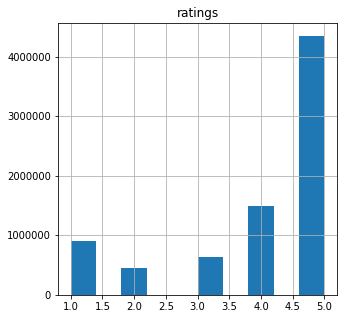

In [10]:
products_df.hist(figsize=(5,5),bins=10)
plt.draw()

In [11]:
products_df['userID'].value_counts()

A5JLAU2ARJ0BO     520
ADLVFFE4VBT8      501
A3OXHLG6DIBRW8    498
A6FIAB28IS79      431
A680RUE1FDO8B     406
                 ... 
A1TL86LNY9XX5M      1
AJ1PHANAJY2G0       1
A236UOFVH432OD      1
A3ESUHQHQN539D      1
A283YV5S6E6700      1
Name: userID, Length: 4201696, dtype: int64

In [0]:
filtered=products_df.groupby('userID').filter(lambda x: len(x) >= 70)

In [0]:
#filtered.to_csv('gdrive/My Drive/Colab Notebooks/new_ratings1.csv')
#filtered = pd.read_csv('gdrive/My Drive/Colab Notebooks/new_ratings.csv')

In [13]:
filtered['ratings'].value_counts()

5.0    42594
4.0    20464
3.0     7463
2.0     3221
1.0     2940
Name: ratings, dtype: int64

In [0]:
counts=products_df['userID'].value_counts()

In [15]:
counts

A5JLAU2ARJ0BO     520
ADLVFFE4VBT8      501
A3OXHLG6DIBRW8    498
A6FIAB28IS79      431
A680RUE1FDO8B     406
                 ... 
A1TL86LNY9XX5M      1
AJ1PHANAJY2G0       1
A236UOFVH432OD      1
A3ESUHQHQN539D      1
A283YV5S6E6700      1
Name: userID, Length: 4201696, dtype: int64

In [16]:
counts[counts>=50]

A5JLAU2ARJ0BO     520
ADLVFFE4VBT8      501
A3OXHLG6DIBRW8    498
A6FIAB28IS79      431
A680RUE1FDO8B     406
                 ... 
AY4EXFOO43C3S      50
A274X54O9CN2SR     50
A3UW0PQLDUACMH     50
A1OES7R7FDAT2L     50
A3BY5KCNQZXV5U     50
Name: userID, Length: 1540, dtype: int64

In [0]:
data_df=products_df[products_df['userID'].isin(counts[counts >= 50].index)]

In [0]:
data_df1=data_df.sort_values(by ='ratings' , ascending=False).reset_index()

In [19]:
data_df1.head()

,index,userID,productID,ratings
0,93,A3BY5KCNQZXV5U,0594451647,5.0
1,4256668,A680RUE1FDO8B,B004M8RWDE,5.0
2,4258496,AOMEH9W6LHC4S,B004M8SBNE,5.0
3,4258198,A2GKMXRLI7KLFP,B004M8SBD4,5.0
4,4258098,A1UNJ46NSB352E,B004M8SBCK,5.0


In [20]:
data_df1.shape

(125871, 4)

In [21]:
data_df.head()

,userID,productID,ratings
93,A3BY5KCNQZXV5U,0594451647,5.0
117,AT09WGFUM934H,0594481813,3.0
176,A32HSNCNPRUMTR,0970407998,1.0
177,A17HMM1M7T9PJ1,0970407998,4.0
491,A3CLWR1UUZT6TG,0972683275,5.0


In [22]:
data_df.shape

(125871, 3)

In [23]:
filtered.head()

,userID,productID,ratings
117,AT09WGFUM934H,0594481813,3.0
176,A32HSNCNPRUMTR,0970407998,1.0
177,A17HMM1M7T9PJ1,0970407998,4.0
630,A3TAS1AG6FMBQW,0972683275,5.0
1321,A1A5KUIIIHFF4U,1400501466,1.0


In [24]:
filtered.shape

(76682, 3)

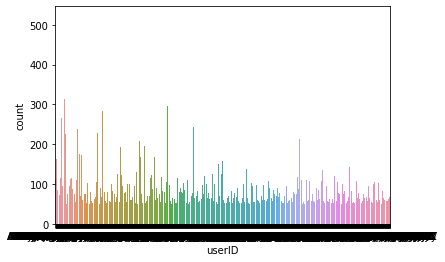

In [25]:
sns.countplot(data_df['userID'])
plt.show()

In [26]:
data_df.isna().sum()

userID       0
productID    0
ratings      0
dtype: int64

In [27]:
filtered.isna().sum()

userID       0
productID    0
ratings      0
dtype: int64

In [28]:
data_df.isnull().sum()

userID       0
productID    0
ratings      0
dtype: int64

In [29]:
filtered.isnull().sum()

userID       0
productID    0
ratings      0
dtype: int64

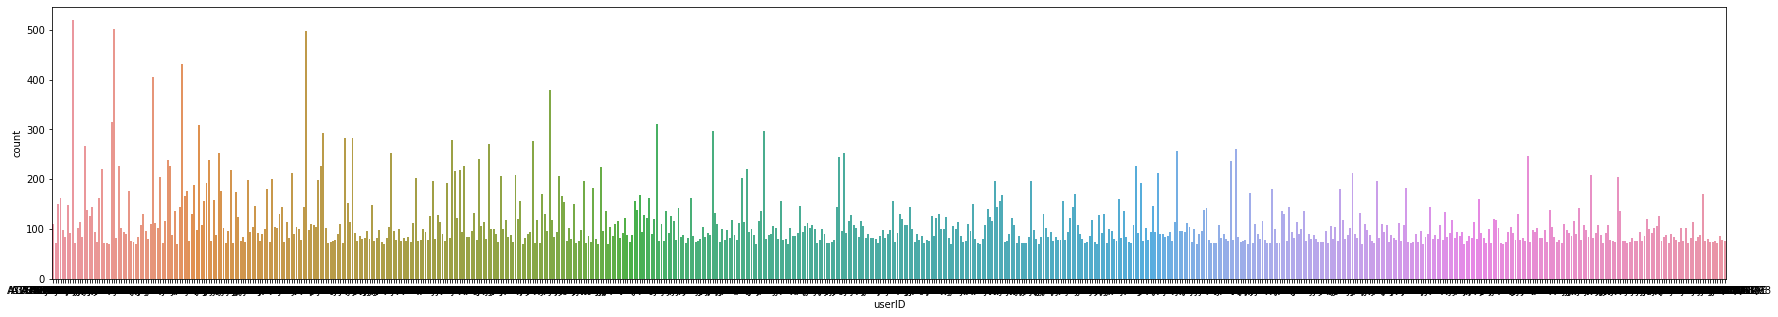

In [30]:
plt.figure(figsize=(30, 5))
sns.countplot(filtered['userID'])
plt.show()

In [31]:
n_users = filtered.userID.unique().shape[0]
n_items = filtered.productID.unique().shape[0]

print(n_users,'\n')
print(n_items)

688 

33428


In [0]:
user_rating = filtered.pivot_table(index='userID', columns='productID', values='ratings').fillna(0)

In [33]:
user_rating

productID,0594481813,0970407998,0972683275,1400501466,1400501776,1400532620,1400532655,1400599997,1400699169,1685560148,7562434166,787988002X,8862935307,8862936826,9043413585,9573212900,9573212919,9575871979,9800359788,9981719005,9981739588,998376234X,9983891212,9984922626,9985511298,9985696999,9989360391,B000000O48,B000001OL6,B000001OM4,B000001OM5,B000001OMI,B000001OMN,B000001ON0,B000001ON6,B00000DM9M,B00000DM9W,B00000IGBF,B00000J03B,B00000J040,...,B00KOUIC0Q,B00KPRWAX8,B00KPXQQK0,B00KR0QHXW,B00KR6FY94,B00KRI1AP4,B00KSTODWY,B00KT17TZ4,B00KTIYN7O,B00KU4RD4M,B00KVLY8E2,B00KVNY2KA,B00KW3OFG0,B00KWHMR6G,B00KWL62QI,B00KWMNDDM,B00KWPRSJY,B00KWWY1PQ,B00KXAFYZS,B00KXMN08E,B00KYA7CT8,B00KYMCJF8,B00L0YFJHY,B00L1I727Y,B00L1I80K2,B00L1NZTSS,B00L21HC7A,B00L2442H0,B00L26YDA4,B00L2P3TRS,B00L3YHF6O,B00L403O94,B00L43HAY6,B00L5YZCCG,B00L8I6SFY,B00LA6T0LS,B00LBZ1Z7K,B00LGQ6HL8,B00LI4ZZO8,B00LKG1MC8
userID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
A100UD67AHFODS,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A100WO06OQR8BQ,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A105TOJ6LTVMBG,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A10NMELR4KX0J6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A10O7THJ2O20AG,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
AYNAH993VDECT,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AYOTEJ617O60K,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AZ515FFZ7I2P7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0

In [34]:
user_rating.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
productID,,,,,,,,
0594481813,688.0,0.004360,0.114374,0.0,0.0,0.0,0.0,3.0
0970407998,688.0,0.007267,0.157138,0.0,0.0,0.0,0.0,4.0
0972683275,688.0,0.007267,0.190623,0.0,0.0,0.0,0.0,5.0
1400501466,688.0,0.005814,0.120508,0.0,0.0,0.0,0.0,3.0
1400501776,688.0,0.005814,0.152499,0.0,0.0,0.0,0.0,4.0
...,...,...,...,...,...,...,...,...
B00LA6T0LS,688.0,0.011628,0.215509,0.0,0.0,0.0,0.0,4.0
B00LBZ1Z7K,688.0,0.004360,0.114374,0.0,0.0,0.0,0.0,3.0
B00LGQ6HL8,688.0,0.036337,0.425004,0.0,0.0,0.0,0.0,5.0


In [0]:
users_rating_matrix = user_rating.values

In [36]:
users_rating_matrix

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [0]:
users_ids = list(user_rating.index)

In [38]:
users_rating_sparse_matrix = csr_matrix(users_rating_matrix)
users_rating_sparse_matrix

<688x33428 sparse matrix of type '<class 'numpy.float64'>'
	with 76682 stored elements in Compressed Sparse Row format>

In [0]:
user_id = 'A100UD67AHFODS'

In [39]:
filtered_edf = filtered.groupby('productID')['ratings'].count().sort_values(ascending=False)
filtered_edf.head()

productID
B0088CJT4U    131
B003ES5ZUU    103
B000N99BBC    100
B002R5AM7C     99
B00829TIEK     97
Name: ratings, dtype: int64

In [40]:
filtered_edf.shape

(33428,)

In [41]:
ratings_mean_count = pd.DataFrame(filtered.groupby('productID')['ratings'].mean()) 
ratings_mean_count

,ratings
productID,
0594481813,3.0
0970407998,2.5
0972683275,5.0
1400501466,2.0
1400501776,4.0
...,...
B00LA6T0LS,4.0
B00LBZ1Z7K,3.0
B00LGQ6HL8,5.0


In [42]:
ratings_mean_count.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
ratings,33428.0,4.218558,1.02832,1.0,4.0,4.555556,5.0,5.0


In [43]:
ratings_mean_count = pd.merge(ratings_mean_count,filtered_edf,on='productID')
ratings_mean_count.columns = ['ratings', 'ratings_count']
ratings_mean_count=ratings_mean_count.sort_values(by='ratings_count',ascending=False)

#ratings_mean_count.drop(['ratings_x'], axis=1, inplace=True)
#ratings_mean_count.rename(columns={"ratings_x": "ratings", "ratings_y": "ratings_count"})

ratings_mean_count

,ratings,ratings_count
productID,,
B0088CJT4U,4.213740,131
B003ES5ZUU,4.893204,103
B000N99BBC,4.760000,100
B002R5AM7C,4.191919,99
B00829TIEK,4.371134,97
...,...,...
B001MQA66E,5.000000,1
B001MQ9S2C,5.000000,1
B001MQ8AXA,5.000000,1


In [44]:
ratings_mean_count.head(10)

,ratings,ratings_count
productID,,
B0088CJT4U,4.213740,131
B003ES5ZUU,4.893204,103
B000N99BBC,4.760000,100
B002R5AM7C,4.191919,99
B00829TIEK,4.371134,97
B008DWCRQW,4.129032,93
B007WTAJTO,4.674419,86
B00829THK0,4.397436,78
B004CLYEDC,4.649351,77


The above top 10 products can be recommended to a new user as recommendation to avoid the cold-start problem.

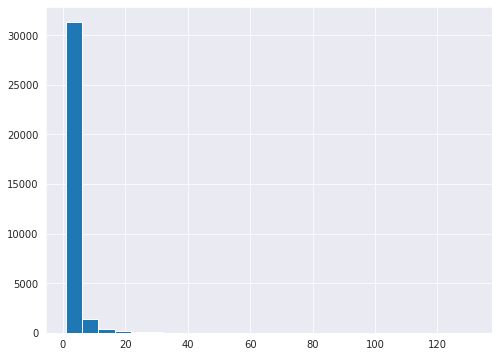

In [45]:
sns.set_style('dark')
plt.figure(figsize=(8,6))
plt.rcParams['patch.force_edgecolor'] = True
ratings_mean_count['ratings_count'].hist(bins=25)
plt.show()

From the output, you can see that most of the products have received less than 50 ratings. While the number of products having more than 50 ratings is very low or nil.

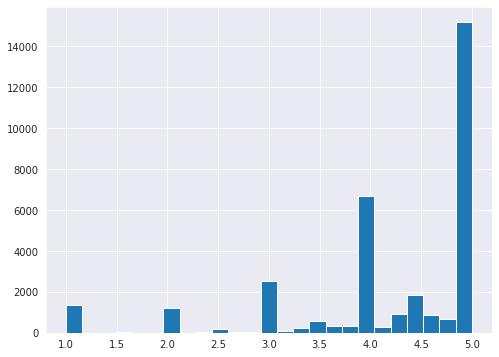

In [46]:
plt.figure(figsize=(8,6))
plt.rcParams['patch.force_edgecolor'] = True
ratings_mean_count['ratings'].hist(bins=25)
plt.show()

You can see that the integer values have taller bars than the floating values since most of the users assign rating as integer value i.e. 1, 2, 3, 4 or 5. Furthermore, it is evident that the data has a weak normal distribution with the mean of around 4.21 and there are a few outliers in the data.

A higher number of ratings usually have a high average rating as well since a good product is normally well-known and a well-known product is bought by a large number of people, and thus usually has a higher rating. 
Let's see if this is also the case with the products in our dataset. As we will plot average ratings against the number of ratings as shown below =>

<Figure size 576x432 with 0 Axes>

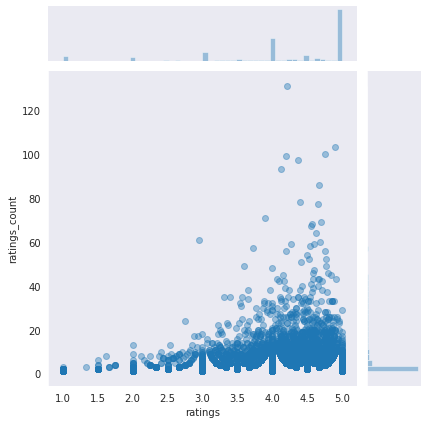

In [47]:
plt.figure(figsize=(8,6))
plt.rcParams['patch.force_edgecolor'] = True
sns.jointplot(x='ratings', y='ratings_count', data=ratings_mean_count, alpha=0.4)
plt.show()

The graph shows that, in general, products with higher average ratings actually have more number of ratings, compared with products that have lower average ratings.

In [0]:
mean_rating_dataset = np.mean(ratings_mean_count.ratings.values)
min_votes = 5

In [0]:
def weighted_rating(rating_mean_count, min_votes, mean_rating_dataset):
    weighted_rating = list()
    V = ratings_mean_count.ratings_count.values
    R = ratings_mean_count.ratings.values
    for v, r in zip(V, R):
        if v < 5:
            weighted_rating.append(0)
        else:
            weighted_rating.append((v/(v+min_votes))*r + (min_votes/(v+min_votes))*mean_rating_dataset)
    return(weighted_rating)

In [0]:
ratings_mean_count['weighted_rating'] = weighted_rating(ratings_mean_count, min_votes, mean_rating_dataset)

In [54]:
ratings_mean_count.weighted_rating.sort_values(ascending = False).head(10)

productID
B0052SCU8U    4.885082
B003ES5ZUU    4.861970
B000067RT6    4.837200
B001TH7GUU    4.835267
B00BQ4F9ZA    4.830786
B0036Q7MV0    4.824743
B00ISFNSBW    4.822400
B00HZWJGS8    4.813942
B0000BZL1P    4.809445
B003FVJYF8    4.804640
Name: weighted_rating, dtype: float64

# **Split the data randomly into train and test dataset.**

In [0]:
# Load data for alogorithm training
X=filtered.drop(labels='ratings',axis=1)
Y=filtered.ratings

In [0]:
X=X.values
Y=Y.values

In [0]:
X_train,X_test,Y_train,Y_test=train_test_split(X,Y,test_size=0.30,random_state=7)

In [0]:
#trainset = data.build_full_trainset()
#testset = trainset.build_anti_testset()

In [0]:
# Load data for alogorithm training

#filtered = pd.read_csv('gdrive/My Drive/Colab Notebooks/new_ratings1.csv')
#filtered.columns = ['userID',  'productID', 'ratings']
reader = Reader()
data = Dataset.load_from_df(filtered[['userID','productID','ratings']],reader)
trainset, testset = train_test_split(data, test_size=0.3, random_state=47)

In [61]:
trainset.ur

defaultdict(list,
            {0: [(0, 5.0),
              (521, 4.0),
              (531, 5.0),
              (691, 3.0),
              (1035, 4.0),
              (1801, 5.0),
              (1819, 5.0),
              (2616, 5.0),
              (3671, 5.0),
              (3655, 4.0),
              (3815, 5.0),
              (4233, 4.0),
              (355, 4.0),
              (4432, 5.0),
              (4652, 4.0),
              (3613, 4.0),
              (1273, 5.0),
              (6397, 5.0),
              (7123, 5.0),
              (3318, 4.0),
              (7754, 5.0),
              (8156, 4.0),
              (7193, 5.0),
              (1544, 5.0),
              (2450, 5.0),
              (11694, 5.0),
              (1883, 4.0),
              (12105, 5.0),
              (6502, 4.0),
              (143, 5.0),
              (12476, 5.0),
              (6613, 5.0),
              (12717, 5.0),
              (13216, 5.0),
              (13727, 5.0),
              (13862, 5.0),
        

In [62]:
testset

[('A250AXLRBVYKB4', 'B001QUA6R0', 5.0),
 ('A31ICLWQ9CSHRS', 'B00E87OITK', 5.0),
 ('A1PVJICI412IN4', 'B000IVDTSG', 5.0),
 ('A1Z16630QMH8Q6', 'B007S642BW', 5.0),
 ('A2QI2NTDTMK2FV', 'B0017U8FVI', 4.0),
 ('A11KZ906QD08C5', 'B0007XDI54', 5.0),
 ('A2UOHALGF2X77Q', 'B000Q82PIQ', 5.0),
 ('A5JLAU2ARJ0BO', 'B00006HYPV', 1.0),
 ('A1N5FSCYN4796F', 'B001QV8OI2', 4.0),
 ('A3N4VTNFPMTHEF', 'B002BH3Z8E', 4.0),
 ('A2FRKEXDXDN1KI', 'B008MJ01QE', 5.0),
 ('A1PM7HH4F77NEH', 'B001E5CDSW', 4.0),
 ('A3NHUQ33CFH3VM', 'B000031KIM', 4.0),
 ('A1UQBFCERIP7VJ', 'B009E1IDLE', 5.0),
 ('A2WB7LZ595CR50', 'B0007M6104', 1.0),
 ('A1BBYSMT9YCODI', 'B006T7KQDO', 4.0),
 ('A2L90SGUP36KGA', 'B003ELYQGG', 3.0),
 ('A3B20R4ZAH0Y2Y', 'B005DEW4BQ', 4.0),
 ('AEJAGHLC675A7', 'B00634PLTW', 5.0),
 ('A34BZM6S9L7QI4', 'B00539I57S', 4.0),
 ('A2V5M5EJPOD2IU', 'B00A7VYO90', 5.0),
 ('A1E1LEVQ9VQNK', 'B00DKBU5W4', 5.0),
 ('A1QVFHPY8418HC', 'B001IZYV3S', 2.0),
 ('ALRCAGJOJ9583', 'B00AQRUW4Q', 3.0),
 ('AGGAQLXPVGM5D', 'B004GK0GKO', 3.0),
 ('AV

In [63]:
algo = KNNWithMeans()
algo.fit(trainset)
predictions = algo.test(testset)

Computing the msd similarity matrix...
Done computing similarity matrix.


In [64]:
# Compute and print Root Mean Squared Error
accuracy.rmse(predictions, verbose=True)

RMSE: 1.0678


1.067767157053219

In [65]:
predictions

[Prediction(uid='A250AXLRBVYKB4', iid='B001QUA6R0', r_ui=5.0, est=4.073565186718884, details={'actual_k': 11, 'was_impossible': False}),
 Prediction(uid='A31ICLWQ9CSHRS', iid='B00E87OITK', r_ui=5.0, est=4.1568627450980395, details={'actual_k': 0, 'was_impossible': False}),
 Prediction(uid='A1PVJICI412IN4', iid='B000IVDTSG', r_ui=5.0, est=4.076923076923077, details={'actual_k': 0, 'was_impossible': False}),
 Prediction(uid='A1Z16630QMH8Q6', iid='B007S642BW', r_ui=5.0, est=4.964556962025316, details={'actual_k': 1, 'was_impossible': False}),
 Prediction(uid='A2QI2NTDTMK2FV', iid='B0017U8FVI', r_ui=4.0, est=3.6440894135158706, details={'actual_k': 4, 'was_impossible': False}),
 Prediction(uid='A11KZ906QD08C5', iid='B0007XDI54', r_ui=5.0, est=5, details={'actual_k': 1, 'was_impossible': False}),
 Prediction(uid='A2UOHALGF2X77Q', iid='B000Q82PIQ', r_ui=5.0, est=4.699737877217211, details={'actual_k': 5, 'was_impossible': False}),
 Prediction(uid='A5JLAU2ARJ0BO', iid='B00006HYPV', r_ui=1.0, 

In [0]:
from collections import defaultdict
def get_top_n(predictions, n=10):
    # First map the predictions to each user.
    top_n = defaultdict(list)
    for uid, iid, true_r, est, _ in predictions:
        top_n[uid].append((iid, est))

    # Then sort the predictions for each user and retrieve the k highest ones.
    for uid, user_ratings in top_n.items():
        user_ratings.sort(key=lambda x: x[1], reverse=True)
        top_n[uid] = user_ratings[:n]

    return top_n

In [0]:
top_n = get_top_n(predictions, n=10)

In [68]:
top_n

defaultdict(list,
            {'A100UD67AHFODS': [('B00FISD9DO', 5),
              ('B0054JJ0QW', 5),
              ('B00F0DD0I6', 5),
              ('B00HHRP11C', 4.98982697490207),
              ('B000233WJ6', 4.987028694137449),
              ('B00176NOCM', 4.885238095238095),
              ('B0053T4PHC', 4.850069013112491),
              ('B009LL9VDG', 4.816498966864914),
              ('B0097BEFYA', 4.743309341920463),
              ('B0097BEF1S', 4.742392566782811)],
             'A100WO06OQR8BQ': [('B0002L5R78', 4.286752471307109),
              ('B005MR6CNK', 4.260055517260652),
              ('B004P8AF30', 4.260055517260652),
              ('B003DPS3DA', 4.260055517260652),
              ('B002CTOWQU', 4.260055517260652),
              ('B002PHM572', 4.260055517260652),
              ('B008ABO6EM', 4.260055517260652),
              ('B0028ACYEK', 4.260055517260652),
              ('B00007CW54', 4.260055517260652),
              ('B004YLCH0C', 4.260055517260652)],
             

The above top 10 products can be recommended to a new user as recommendation to avoid the cold-start problem.

In [69]:
for uid, user_ratings in top_n.items():
    print(uid, [iid for (iid, _) in user_ratings])

A250AXLRBVYKB4 ['B0028N6XDA', 'B00005LEN4', 'B0037LQY7M', 'B006JINHYS', 'B001O9EUSO', 'B000OGX5AM', 'B002PU9SQU', 'B002G1YPH0', 'B001TH7GSW', 'B000083JZH']
A31ICLWQ9CSHRS ['B000MUXJCO', 'B001B8RSAK', 'B00007GQLS', 'B00006B9CR', 'B000I1X3W8', 'B000VJX7DW', 'B000FBK3QK', 'B00009R6WO', 'B000HJPK2C', 'B0001UEHHG']
A1PVJICI412IN4 ['B0009S5HQA', 'B0015VW3BM', 'B001F42MKG', 'B002UUPWP6', 'B000E8X5Z0', 'B00APP6694', 'B00DVFLJDS', 'B0018LX0DY', 'B005BGKAGC', 'B00576LAXI']
A1Z16630QMH8Q6 ['B00333F2YU', 'B00D1GYNT4', 'B001O92JFK', 'B000V1R96Q', 'B004CLYEDC', 'B00BWF5U0M', 'B0041OSAZ8', 'B001D7REIK', 'B00IVFDZBC', 'B000BSN4UY']
A2QI2NTDTMK2FV ['B001U0OGQS', 'B003P2UMQ2', 'B00FH2MV80', 'B001NTBVPA', 'B004CLYEDC', 'B00HMREOLK', 'B00DDK1QUC', 'B00ANII768', 'B000023MCH', 'B002TV5M5G']
A11KZ906QD08C5 ['B0007XDI54', 'B001TZWNF0', 'B0007WK8KS', 'B008NENG1A', 'B00GZNCP3G', 'B0053FR9FQ', 'B004GF8TIK', 'B0011000R6', 'B00009UTLM', 'B002WE6D44']
A2UOHALGF2X77Q ['B002OJN250', 'B00JXUUVWU', 'B004U78J1G', 'B001G

In [72]:
algo1 = SVD()
algo1.fit(trainset)
predictions1 = algo1.test(testset)
predictions1

[Prediction(uid='A250AXLRBVYKB4', iid='B001QUA6R0', r_ui=5.0, est=3.9697348035901667, details={'was_impossible': False}),
 Prediction(uid='A31ICLWQ9CSHRS', iid='B00E87OITK', r_ui=5.0, est=4.23901168719705, details={'was_impossible': False}),
 Prediction(uid='A1PVJICI412IN4', iid='B000IVDTSG', r_ui=5.0, est=4.25343320458924, details={'was_impossible': False}),
 Prediction(uid='A1Z16630QMH8Q6', iid='B007S642BW', r_ui=5.0, est=4.768604809554127, details={'was_impossible': False}),
 Prediction(uid='A2QI2NTDTMK2FV', iid='B0017U8FVI', r_ui=4.0, est=3.8109543490759163, details={'was_impossible': False}),
 Prediction(uid='A11KZ906QD08C5', iid='B0007XDI54', r_ui=5.0, est=4.482817335431942, details={'was_impossible': False}),
 Prediction(uid='A2UOHALGF2X77Q', iid='B000Q82PIQ', r_ui=5.0, est=4.37053324598847, details={'was_impossible': False}),
 Prediction(uid='A5JLAU2ARJ0BO', iid='B00006HYPV', r_ui=1.0, est=3.530836320080347, details={'was_impossible': False}),
 Prediction(uid='A1N5FSCYN4796F', 

In [73]:
# Compute and print Root Mean Squared Error
accuracy.rmse(predictions1, verbose=True)

RMSE: 0.9786


0.9785786645360167

In [0]:
# To use item-based cosine similarity
sim_options = {
    "name": "cosine",
    "user_based": False,  # Compute  similarities between items
}
algo2 = KNNWithMeans(k=50,sim_options=sim_options)

In [0]:
# define a cross-validation iterator
kf = KFold(n_splits=3)

In [0]:
# Train the model
for trainset, testset in kf.split(data):

    # train and test algorithm.
    algo2.fit(trainset)
    predictions2 = algo2.test(testset)

    # Compute and print Root Mean Squared Error
    accuracy.rmse(predictions2, verbose=True)

Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 1.1021
Computing the cosine similarity matrix...


In [0]:
sim_options = {
    "name": ["msd", "cosine"],
    "min_support": [3, 4, 5],
    "user_based": [False, True],
}

param_grid = {"sim_options": sim_options}

gs = GridSearchCV(KNNWithMeans, param_grid, measures=["rmse", "mae"], cv=3)
gs.fit(data)

print(gs.best_score["rmse"])
print(gs.best_params["rmse"])

Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computi

In [0]:
sim_options = {
    "name": ["msd", "cosine"],
    "min_support": [3, 4, 5],
    "user_based": [False, True],
}

param_grid = {"sim_options": sim_options}

gs = GridSearchCV(KNNWithMeans, param_grid, measures=["rmse", "mae"], cv=3)
gs.fit(data)

print(gs.best_score["rmse"])
print(gs.best_params["rmse"])

Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computi

In this notebook, we've explored and compared the main Recommender Systems techniques on e-commerce website Amazon dataset. It could be observed that for products recommendation to a new user, we performed Popularity based model and Collaborative Filtering model, to solve the cold-start problem.